# TabNet — Deep Neural Network for Structured, Tabular Data

Author: Ryan Burke

Article from [towardsdatascience.com](https://towardsdatascience.com/tabnet-deep-neural-network-for-structured-tabular-data-39eb4b27a9e4).

> Note: In this notebook, I am studying the article mentioned above. Some changes may have been made to the code during its implementation.

# Library

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from numpy import isnan
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split

import missingno as msno

import pytorch_tabnet
from pytorch_tabnet.tab_model import TabNetClassifier
from pytorch_tabnet.pretraining import TabNetPretrainer

import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import KFold

np.random.seed(8)

sns.set_style("white")

# Creating the data frame

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/singator/bdah/master/data/frmgham2.csv')
df.head()

,RANDID,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,...,CVD,HYPERTEN,TIMEAP,TIMEMI,TIMEMIFC,TIMECHD,TIMESTRK,TIMECVD,TIMEDTH,TIMEHYP
0,2448,1,195.0,39,106.0,70.0,0,0.0,26.97,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
1,2448,1,209.0,52,121.0,66.0,0,0.0,NaN,0,...,1,0,8766,6438,6438,6438,8766,6438,8766,8766
2,6238,2,250.0,46,121.0,81.0,0,0.0,28.73,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
3,6238,2,260.0,52,105.0,69.5,0,0.0,29.43,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766
4,6238,2,237.0,58,108.0,66.0,0,0.0,28.50,0,...,0,0,8766,8766,8766,8766,8766,8766,8766,8766


In [3]:
df2 = df[["SEX","TOTCHOL", "AGE", "SYSBP", "DIABP", "CURSMOKE",
                "CIGPDAY", "BMI", "DIABETES", "BPMEDS", "HEARTRTE", "GLUCOSE", "educ",
                "HDLC", "LDLC", "ANYCHD", "PERIOD"]].copy()

In [4]:
df2 = df2[(df2.PERIOD == 3)]

In [5]:
df2 = df2.drop(columns='PERIOD')

In [6]:
df2.shape

(3263, 16)

In [7]:
df2.head()

,SEX,TOTCHOL,AGE,SYSBP,DIABP,CURSMOKE,CIGPDAY,BMI,DIABETES,BPMEDS,HEARTRTE,GLUCOSE,educ,HDLC,LDLC,ANYCHD
1,1,209.0,52,121.0,66.0,0,0.0,NaN,0,0.0,69.0,92.0,4.0,31.0,178.0,1
4,2,237.0,58,108.0,66.0,0,0.0,28.50,0,0.0,80.0,71.0,2.0,54.0,141.0,0
11,2,NaN,58,155.0,90.0,1,30.0,24.61,0,0.0,74.0,NaN,3.0,NaN,NaN,0
14,2,220.0,55,180.0,106.0,0,0.0,31.17,1,1.0,86.0,81.0,2.0,46.0,135.0,1
19,2,320.0,57,110.0,46.0,1,30.0,22.02,0,0.0,75.0,87.0,2.0,34.0,286.0,0


In [8]:
for col in ['SEX','CURSMOKE', 'DIABETES', 'ANYCHD']:
    df2[col] = df2[col].astype('category')

In [9]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3263 entries, 1 to 11626
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   SEX       3263 non-null   category
 1   TOTCHOL   3049 non-null   float64 
 2   AGE       3263 non-null   int64   
 3   SYSBP     3263 non-null   float64 
 4   DIABP     3263 non-null   float64 
 5   CURSMOKE  3263 non-null   category
 6   CIGPDAY   3249 non-null   float64 
 7   BMI       3246 non-null   float64 
 8   DIABETES  3263 non-null   category
 9   BPMEDS    2817 non-null   float64 
 10  HEARTRTE  3259 non-null   float64 
 11  GLUCOSE   2701 non-null   float64 
 12  educ      3181 non-null   float64 
 13  HDLC      3027 non-null   float64 
 14  LDLC      3026 non-null   float64 
 15  ANYCHD    3263 non-null   category
dtypes: category(4), float64(11), int64(1)
memory usage: 344.6 KB


In [10]:
df2.isnull().sum()

SEX           0
TOTCHOL     214
AGE           0
SYSBP         0
DIABP         0
CURSMOKE      0
CIGPDAY      14
BMI          17
DIABETES      0
BPMEDS      446
HEARTRTE      4
GLUCOSE     562
educ         82
HDLC        236
LDLC        237
ANYCHD        0
dtype: int64

<AxesSubplot:>

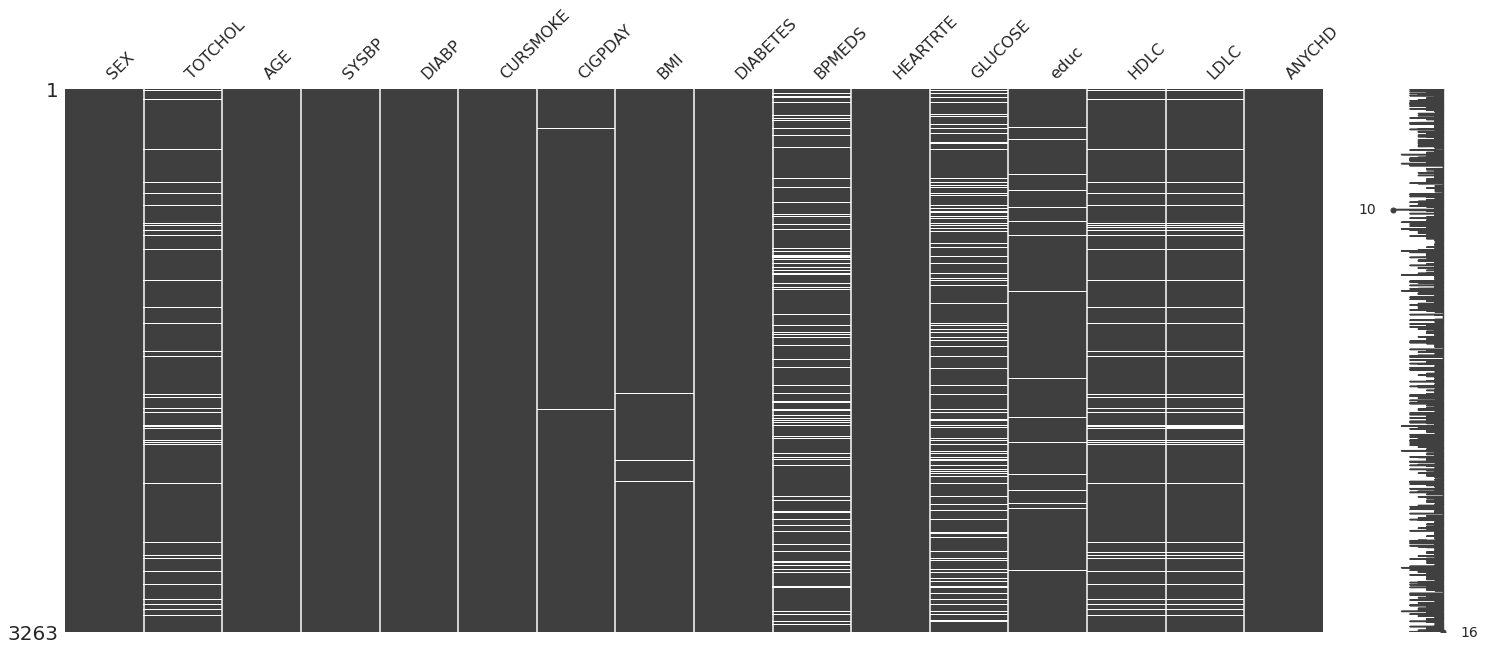

In [11]:
msno.matrix(df2)

<AxesSubplot:>

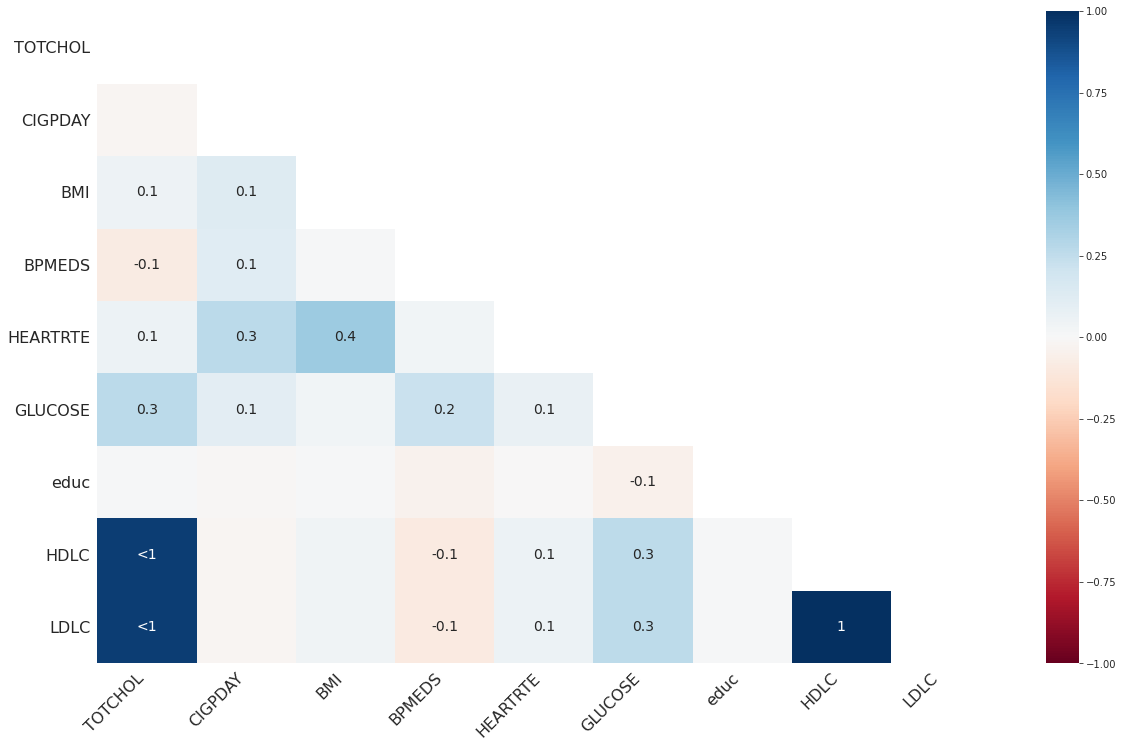

In [12]:
msno.heatmap(df2)

In [13]:
df2.to_csv("datasets/working_data.csv")

# TabNet w/o preprocessing

In [14]:
feat = df2.drop('ANYCHD', axis = 1)

In [15]:
# separate our target and features variables
target = np.array(df2['ANYCHD'])
# Remove the target from the features
# axis 1 refers to the columns
features= df2.drop('ANYCHD', axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [16]:
# print total missing
print('Missing: %d' % sum(isnan(features).flatten()))
# define imputer
imputer = KNNImputer(missing_values=np.nan)
# fit on the dataset
imputer.fit(features)
# transform the dataset
features_trans = imputer.transform(features)
# print total missing
print('Missing: %d' % sum(isnan(features_trans).flatten()))

Missing: 1812
Missing: 0


In [17]:
x_train, x_val, y_train, y_val = train_test_split(features_trans, target, test_size=0.30, random_state=8)

In [18]:
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.50, random_state=8)

In [19]:
print("X train shape: ", x_train.shape)
print("X validation shape: ", x_val.shape)
print("X test shape: ", x_test.shape)
print("Y train shape: ", y_train.shape)
print("Y validation shape: ", y_val.shape)
print("Y test shape: ", y_test.shape)

X train shape:  (2284, 15)
X validation shape:  (489, 15)
X test shape:  (490, 15)
Y train shape:  (2284,)
Y validation shape:  (489,)
Y test shape:  (490,)


In [20]:
clf1_nopreproc = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    n_d=64,  # range 8 - 64 , default = 8
    n_a=64,  # range 8 - 64 , default = 8
    n_steps=5,
    scheduler_params={
        "step_size": 10,  # how to use learning rate scheduler
        "gamma": 0.5
    },
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='entmax',  # "sparsemax",
    device_name='cpu'
)

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [21]:
clf1_nopreproc.fit(
    x_train,y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['accuracy', 'balanced_accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False
)

epoch 0  | loss: 1.07697 | train_accuracy: 0.2732  | train_balanced_accuracy: 0.49907 | valid_accuracy: 0.23926 | valid_balanced_accuracy: 0.49722 |  0:00:02s
epoch 1  | loss: 0.89182 | train_accuracy: 0.54947 | train_balanced_accuracy: 0.55898 | valid_accuracy: 0.59714 | valid_balanced_accuracy: 0.56614 |  0:00:02s
epoch 2  | loss: 0.78475 | train_accuracy: 0.25963 | train_balanced_accuracy: 0.4964  | valid_accuracy: 0.22904 | valid_balanced_accuracy: 0.5     |  0:00:03s
epoch 3  | loss: 0.70536 | train_accuracy: 0.26226 | train_balanced_accuracy: 0.4998  | valid_accuracy: 0.23108 | valid_balanced_accuracy: 0.50133 |  0:00:04s
epoch 4  | loss: 0.63635 | train_accuracy: 0.4479  | train_balanced_accuracy: 0.52282 | valid_accuracy: 0.43967 | valid_balanced_accuracy: 0.53305 |  0:00:05s
epoch 5  | loss: 0.63239 | train_accuracy: 0.27452 | train_balanced_accuracy: 0.50755 | valid_accuracy: 0.24131 | valid_balanced_accuracy: 0.50796 |  0:00:05s
epoch 6  | loss: 0.6319  | train_accuracy: 0.3

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


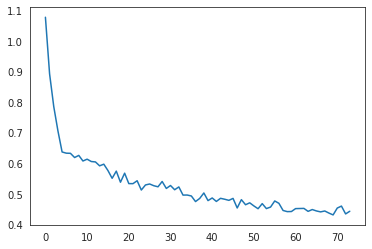

In [22]:
# plot losses
plt.plot(clf1_nopreproc.history['loss'])

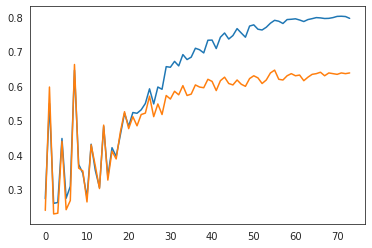

In [28]:
# plot auccuracy
plt.plot(clf1_nopreproc.history['train_accuracy'])
plt.plot(clf1_nopreproc.history['valid_accuracy'])

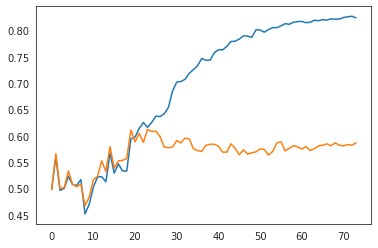

In [29]:
# plot balanced_accuracy
plt.plot(clf1_nopreproc.history['train_balanced_accuracy'])
plt.plot(clf1_nopreproc.history['valid_balanced_accuracy'])

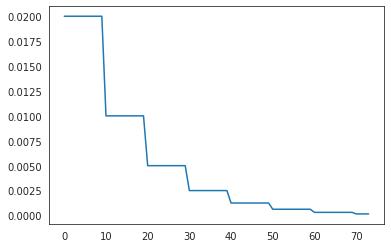

In [30]:
# plot learning rates
plt.plot(clf1_nopreproc.history['lr'])

In [37]:
# determine best accuracy for test set
y_pred = clf1_nopreproc.predict(x_test)
test_acc = balanced_accuracy_score(y_pred, y_test)

# determine best accuracy for validation set
y_pred_valid = clf1_nopreproc.predict(x_val)
valid_acc = balanced_accuracy_score(y_pred_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.5831746031746032
BEST ACCURACY SCORE ON TEST SET : 0.5996540830553644


<AxesSubplot:>

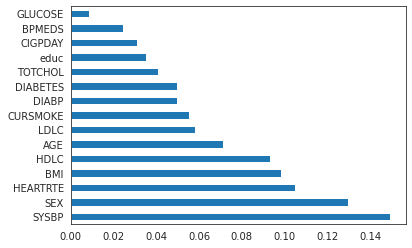

In [32]:
# find and plot feature importance
# y_pred = clf1_nopreproc.predict(x_test)
clf1_nopreproc.feature_importances_
feat_importances = pd.Series(clf1_nopreproc.feature_importances_, index=feat.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [38]:
explain_matrix, masks = clf1_nopreproc.explain(x_test)

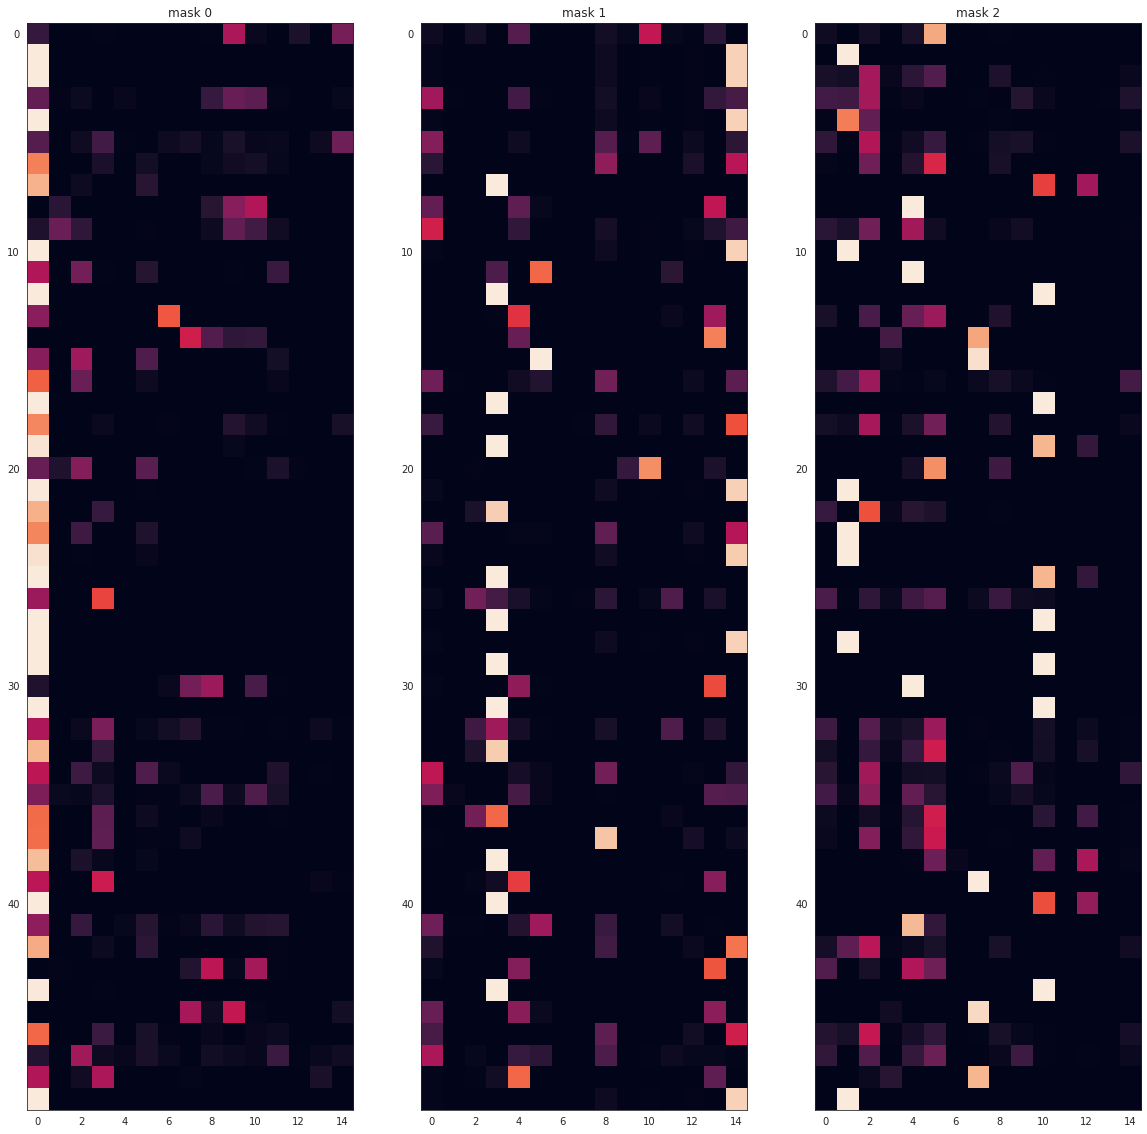

In [39]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")

# Unsupervised pretraining

In [41]:
# TabNetPretrainer
unsupervised_model_no_preproc = TabNetPretrainer(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax', # "sparsemax",
    device_name='cpu'
    )

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [42]:
# fit the model
unsupervised_model_no_preproc.fit(
    x_train,
    eval_set=[x_val],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8
)

epoch 0  | loss: 24.21864| val_0_unsup_loss_numpy: 214.31651306152344|  0:00:00s
epoch 1  | loss: 20.61879| val_0_unsup_loss_numpy: 29.856199264526367|  0:00:00s
epoch 2  | loss: 19.38798| val_0_unsup_loss_numpy: 19.861080169677734|  0:00:00s
epoch 3  | loss: 17.18182| val_0_unsup_loss_numpy: 17.105060577392578|  0:00:01s
epoch 4  | loss: 13.84594| val_0_unsup_loss_numpy: 14.296119689941406|  0:00:01s
epoch 5  | loss: 10.65547| val_0_unsup_loss_numpy: 10.099699974060059|  0:00:01s
epoch 6  | loss: 8.36788 | val_0_unsup_loss_numpy: 7.934909820556641|  0:00:02s
epoch 7  | loss: 6.29987 | val_0_unsup_loss_numpy: 5.7199602127075195|  0:00:02s
epoch 8  | loss: 4.55431 | val_0_unsup_loss_numpy: 4.114709854125977|  0:00:02s
epoch 9  | loss: 3.31454 | val_0_unsup_loss_numpy: 3.1800498962402344|  0:00:03s
epoch 10 | loss: 2.74326 | val_0_unsup_loss_numpy: 2.688110113143921|  0:00:03s
epoch 11 | loss: 2.39142 | val_0_unsup_loss_numpy: 2.3612899780273438|  0:00:03s
epoch 12 | loss: 2.11996 | val_

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [43]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model_no_preproc.predict(x_val)
assert(reconstructed_X.shape==embedded_X.shape)

In [44]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model_no_preproc.explain(x_val)

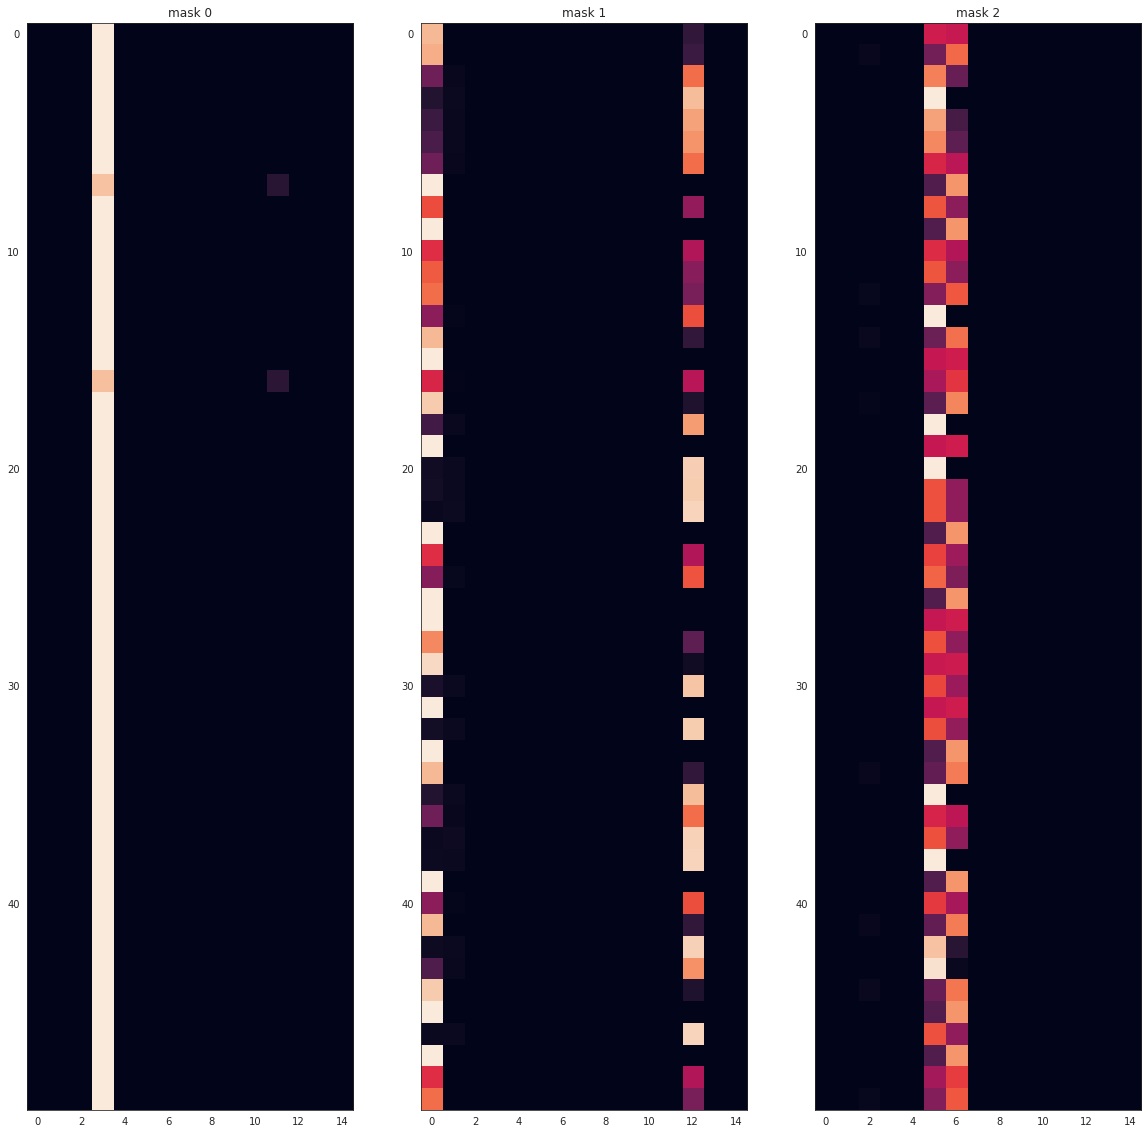

In [45]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")

In [47]:
unsupervised_model_no_preproc.save_model('./pickle-objects/test_pretrain2')
loaded_pretrain = TabNetPretrainer(device_name='cpu')
loaded_pretrain.load_model('./pickle-objects/test_pretrain2.zip')

Successfully saved model at ./pickle-objects/test_pretrain2.zip


/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [48]:
clf2_no_preproc = TabNetClassifier(
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    scheduler_params={
        "step_size": 10,  # how to use learning rate scheduler
        "gamma": 0.9
    },
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    mask_type='sparsemax',  # This will be overwritten if using pretrain model
    device_name='cpu'
)

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:75: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [49]:
clf2_no_preproc.fit(
    x_train, y_train,
    eval_set=[(x_train, y_train), (x_val, y_val)],
    eval_name=['train', 'valid'],
    eval_metric=['auc', 'accuracy'],
    max_epochs=1000 , patience=50,
    batch_size=256, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
)

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:105: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:231: UserWarning: Loading weights from unsupervised pretraining
  warnings.warn("Loading weights from unsupervised pretraining")


epoch 0  | loss: 0.94882 | train_auc: 0.5324  | train_accuracy: 0.25876 | valid_auc: 0.51367 | valid_accuracy: 0.22904 |  0:00:00s
epoch 1  | loss: 0.69987 | train_auc: 0.51849 | train_accuracy: 0.26007 | valid_auc: 0.54694 | valid_accuracy: 0.23108 |  0:00:01s
epoch 2  | loss: 0.67827 | train_auc: 0.58903 | train_accuracy: 0.26313 | valid_auc: 0.64893 | valid_accuracy: 0.23517 |  0:00:02s
epoch 3  | loss: 0.67244 | train_auc: 0.5824  | train_accuracy: 0.26182 | valid_auc: 0.60563 | valid_accuracy: 0.23313 |  0:00:02s
epoch 4  | loss: 0.66814 | train_auc: 0.5699  | train_accuracy: 0.26313 | valid_auc: 0.59722 | valid_accuracy: 0.23108 |  0:00:03s
epoch 5  | loss: 0.66279 | train_auc: 0.55459 | train_accuracy: 0.30254 | valid_auc: 0.61572 | valid_accuracy: 0.27812 |  0:00:03s
epoch 6  | loss: 0.67104 | train_auc: 0.59213 | train_accuracy: 0.26095 | valid_auc: 0.67774 | valid_accuracy: 0.23108 |  0:00:03s
epoch 7  | loss: 0.66028 | train_auc: 0.53627 | train_accuracy: 0.30035 | valid_auc

/mnt/Dados/Mestrado_Computacao_Aplicada_UFMS/1_semestre/Inteligencia_Artificial/algoritmos-ia/venv/lib/python3.8/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


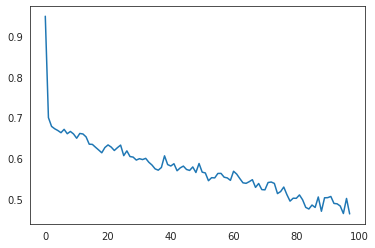

In [50]:
# plot losses
plt.plot(clf2_no_preproc.history['loss'])

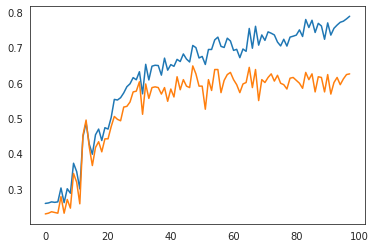

In [51]:
# plot auc
plt.plot(clf2_no_preproc.history['train_accuracy'])
plt.plot(clf2_no_preproc.history['valid_accuracy'])

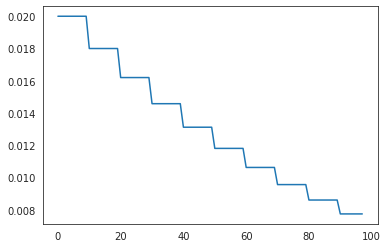

In [52]:
# plot learning rates
plt.plot(clf2_no_preproc.history['lr'])

In [53]:
preds = clf2_no_preproc.predict(x_test)
test_acc = accuracy_score(preds, y_test)


preds_valid = clf2_no_preproc.predict(x_val)
valid_acc = accuracy_score(preds_valid, y_val)

print(f"BEST ACCURACY SCORE ON VALIDATION SET : {valid_acc}")
print(f"BEST ACCURACY SCORE ON TEST SET : {test_acc}")

BEST ACCURACY SCORE ON VALIDATION SET : 0.6482617586912065
BEST ACCURACY SCORE ON TEST SET : 0.6448979591836734


In [54]:
clf2_no_preproc.feature_importances_

array([0.11679904, 0.0159474 , 0.13788759, 0.07150021, 0.16557747,
       0.06029393, 0.08765287, 0.04502599, 0.        , 0.06335575,
       0.03113574, 0.00406586, 0.06169395, 0.01998411, 0.1190801 ])

<AxesSubplot:>

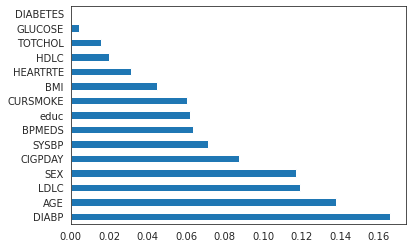

In [55]:
feat_importances = pd.Series(clf2_no_preproc.feature_importances_, index=feat.columns)
feat_importances.nlargest(20).plot(kind='barh')

In [56]:
explain_matrix, masks = clf2_no_preproc.explain(x_test)

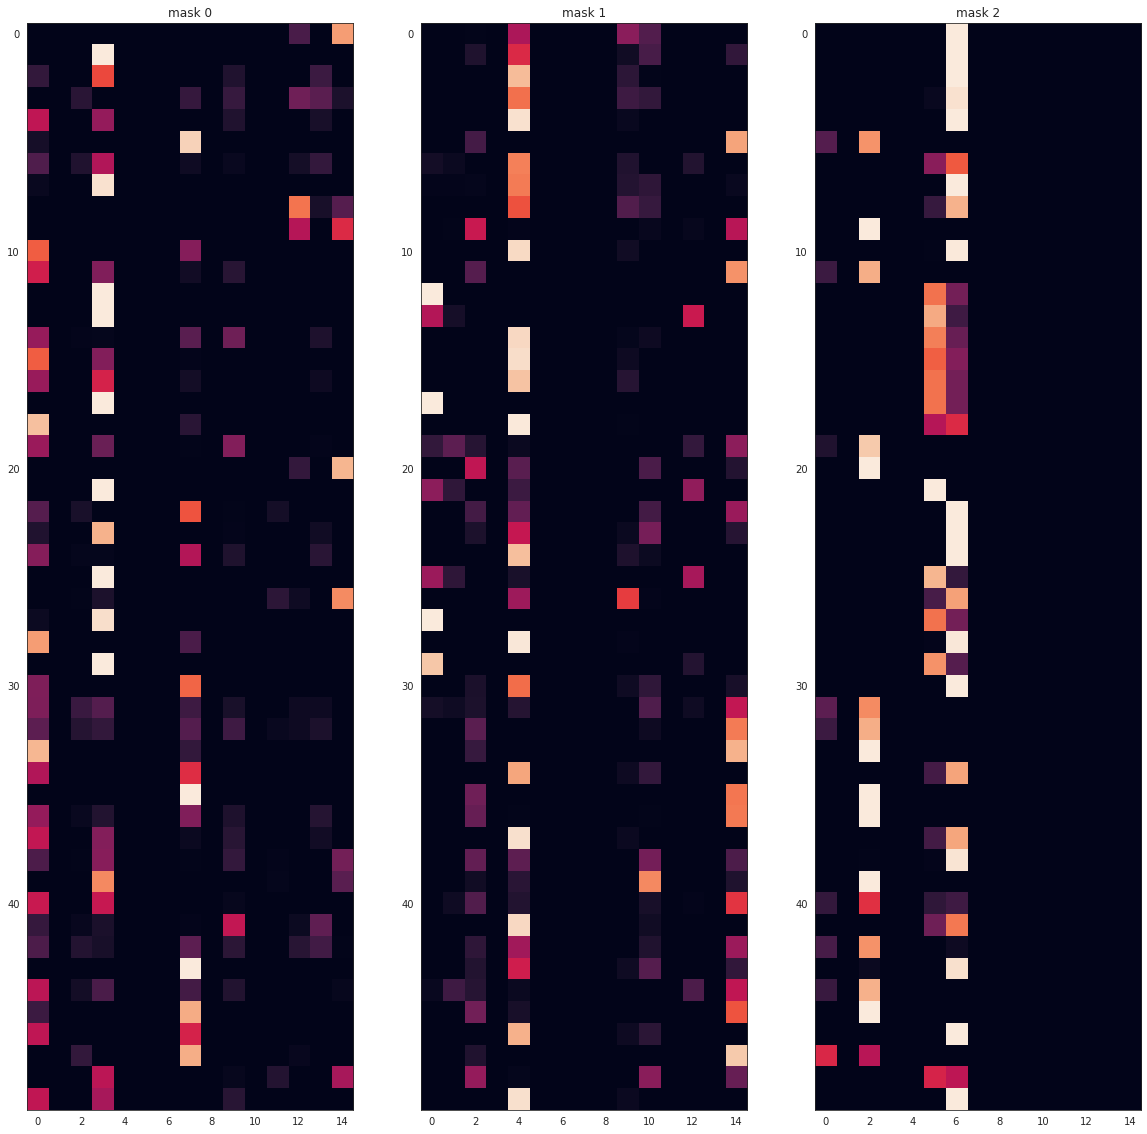

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")